# MATH50003 Numerical Analysis (2022–23)
# Lab 3: Divided differences and dual numbers

This lab explores different discretisations for first and higher derivatives.
In particular we consider the following approximations:
*Forward differences*:
$$
f'(x) ≈ {f(x+h) - f(x) \over h}
$$
*Central differences*:
$$
f'(x) ≈ {f(x+h) - f(x-h) \over 2h}
$$
*Second order differences*:
$$
f''(x) ≈ {f(x+h) - 2f(x) + f(x-h) \over h^2}
$$
We also add to the implementation of `Dual` to enable
automatic differentiation with cos, sin, and division

[0.333333333333333, 0.3333333333333332, 0.3333333333333332, 0.33333333333333365, 0.33333333333333276, 0.33333333333333454, 0.333333333333331, 0.3333333333333381, 0.3333333333333239, 0.3333333333333523, 0.33333333333329546, 0.33333333333340914, 0.33333333333318177, 0.3333333333336365, 0.333333333332727, 0.333333333334546, 0.33333333333090803, 0.333333333338184, 0.3333333333236321, 0.3333333333527359, 0.33333333329452824, 0.33333333341094357, 0.3333333331781129, 0.3333333336437742, 0.33333333271245164, 0.3333333345750968, 0.3333333308498065, 0.3333333233992259, 0.3333333233992259, 0.3333333532015483, 0.3333332935969035, 0.33333341280619305, 0.33333317438761395, 0.33333365122477215, 0.33333269755045575, 0.33333460489908856, 0.33333079020182294, 0.3333384195963542, 0.3333231608072917, 0.3333536783854167, 0.3332926432291667, 0.3334147135416667, 0.3331705729166667, 0.3336588541666667, 0.3326822916666667, 0.3346354166666667, 0.3307291666666667, 0.3385416666666667, 0.3229166666666667, 0.354166

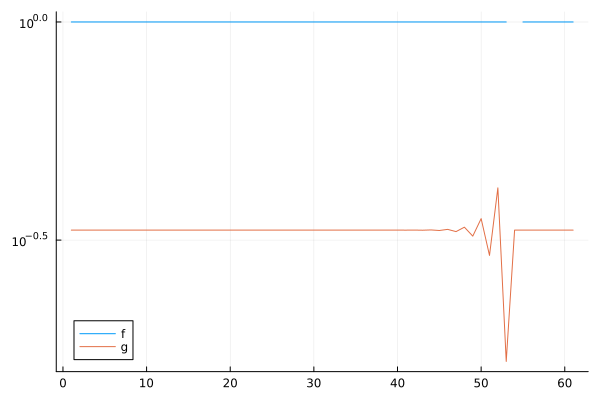

In [30]:
using Plots, Test
# helper function to avoid trying to take logs of 0 in plots
# use in plots below
# Here COND ? EXPR1 : EXPR2
# is another way to write
# if COND
#     EXPR1
# else
#     EXPR2
# end
nanabs = x -> iszero(x) ? NaN : abs(x)

f = x -> 1 + x + x^2
f′ = x -> 1 + 2x
g = x -> 1 + x/3 + x^2
g′ = x -> 1/3 + 2*x

h1 = 2.0 .^ (0:-1:-60)
h2 = 10.0 .^ (0:-1:-16)

# want to produce a vector with the central difference of each 
# element of the vector

x = 0.0
central_f_h1 = ((f.(x .+ h1) .- f.(x .- h1))./h1) .- f′(x)
central_g_h1 = ((g.(x .+ h1) .- g.(x .- h1))./h1) .- g′(x)
print(central_g_h1)

plot(nanabs.(central_f_h1), yaxis=:log10, label="f")
plot!(nanabs.(central_g_h1), yaxis=:log10, label="g")

#central_f_h2 = (f.(x .+ h2) .- f.(x .- h2))./h2
#central_g_h2 = (g.(x .+ h2) .- g.(x .- h2))./h2

--------

**Problem 1** Implement central differences
for $f(x) = 1 + x + x^2$ and $g(x) = 1 + x/3 + x^2$, approximating the derivative at $x = 0$.
Plot the absolute errors for `h = 2.0 .^ (0:-1:-60)` and `h = 10.0 .^ (0:-1:-16)`.

Hint: the easiest way to do this is the copy the code from lectures/notes for forward differences,
and replace the line `f.(h) .- f(0) ./ h` with the equivalent for central differences.
Note that `f.(h)` is broadcast notation so creates a vector containing `[f(h[1]),…,f(h[end])]`.
Thus that expression creates a vector containing `[(f(h[1])-f(0))/h[1], …, (f(h[end])-f(0))/h[end]]`.

-----
**Problem 2** Use forward differences, central differences, and second-order divided differences to approximate to 5-digits the first and second
derivatives to the following functions
at the point $x = 0.1$:
$$
\exp(\exp x \cos x + \sin x), ∏_{k=1}^{1000} \left({x \over k}-1\right), \hbox{ and } f^{\rm s}_{1000}(x)
$$
where $f^{\rm s}_n(x)$ corresponds to $n$-terms of the following continued fraction:
$$
1 + {x-1 \over 2 + {x-1 \over 2 + {x-1 \over 2 + ⋱}}},
$$
e.g.:
$$f^{\rm s}_1(x) = 1 + {x-1 \over 2}$$
$$f^{\rm s}_2(x) = 1 + {x-1 \over 2 + {x -1 \over 2}}$$
$$f^{\rm s}_3(x) = 1 + {x-1 \over 2 + {x -1 \over 2 + {x-1 \over 2}}}$$

----

We now extend our implementation of `Dual` which we began in lectures/notes as follows:

In [2]:
# Dual(a,b) represents a + b*ϵ
struct Dual{T}
    a::T
    b::T
end

# Dual(a) represents a + 0*ϵ
Dual(a::Real) = Dual(a, zero(a)) # for real numbers we use a + 0ϵ

# Allow for a + b*ϵ syntax
const ϵ = Dual(0, 1)

# import the functions which we wish to overload
import Base: +, *, -, /, ^, zero, exp, cos, sin, one

# support polynomials like 1 + x, x - 1, 2x or x*2 by reducing to Dual
+(x::Real, y::Dual) = Dual(x) + y
+(x::Dual, y::Real) = x + Dual(y)
-(x::Real, y::Dual) = Dual(x) - y
-(x::Dual, y::Real) = x - Dual(y)
*(x::Real, y::Dual) = Dual(x) * y
*(x::Dual, y::Real) = x * Dual(y)

# support x/2 (but not yet division of duals)
/(x::Dual, k::Real) = Dual(x.a/k, x.b/k)

# a simple recursive function to support x^2, x^3, etc.
function ^(x::Dual, k::Integer)
    if k < 0
        error("Not implemented")
    elseif k == 1
        x
    else
        x^(k-1) * x
    end
end

# support identity of type Dual
one(x::Dual) = Dual(one(eltype(x.a)))

# Algebraic operations for duals
-(x::Dual) = Dual(-x.a, -x.b)
+(x::Dual, y::Dual) = Dual(x.a + y.a, x.b + y.b)
-(x::Dual, y::Dual) = Dual(x.a - y.a, x.b - y.b)
*(x::Dual, y::Dual) = Dual(x.a*y.a, x.a*y.b + x.b*y.a)

exp(x::Dual) = Dual(exp(x.a), exp(x.a) * x.b)

exp (generic function with 16 methods)

**Problem 3.1** Add support for `cos`, `sin`, and `/` to the type `Dual`

In [3]:
# by replacing the `# TODO`s in the below code.

function cos(x::Dual)
    # TODO: implement cos for Duals

end

function sin(x::Dual)
    # TODO: implement sin for Duals

end

function /(x::Dual, y::Dual)
    # TODO: implement division for Duals

end

x = 0.1
@test_broken cos(sin(x+ϵ)/(x+ϵ)).b ≈ -((cos(x)/x - sin(x)/x^2)sin(sin(x)/x))

Test Broken
  Expression: (cos(sin(x + ϵ) / (x + ϵ))).b ≈ -((cos(x) / x - sin(x) / x ^ 2) * sin(sin(x) / x))

**Problem 3.2** Use dual numbers to compute the derivatives to
$$
\exp(\exp x \cos x + \sin x), ∏_{k=1}^{1000} \left({x \over k}-1\right), \hbox{ and } f^{\rm s}_{1000}(x).
$$
Does your answer match (to 5 digits) Problem 2?

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*